# Assignment 5 - CPU Scheduling Algorithms

## Imports

In [ ]:
import copy
from collections import deque
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## Helper Functions

These are the helper functions to plott and print the results of the scheduling algorithms.

In [ ]:
def print_gantt_chart_text(gantt):
    """
    Prints the Gantt chart in a nice ASCII-art style.
    The chart shows process segments and the timeline.

    Example output:

    +-------------------------------------------------------+
    |   P1    |   P2  |   P1  |   P3    |   P2   |    P1    |
    +---------+-------+-------+---------+--------+----------+
    | 0     2 | 2   4 | 4   6 | 6     8 | 8    9 | 9     10 |
    +-------------------------------------------------------+
    """
    if not gantt:
        print("No Gantt chart data to display.")
        return

    # For each segment, compute a cell width based on its contents.
    cell_widths = []
    top_cells = []  # process labels (e.g., "P1")
    bottom_cells = []  # time intervals (e.g., "0 2")

    for seg in gantt:
        pid, start, end = seg
        top_text = f"P{pid}"
        bottom_text = f"{start} {end}"
        # Compute cell width: add some padding so it looks nice.
        w = max(len(top_text), len(bottom_text)) + 4
        cell_widths.append(w)
        top_cells.append(top_text.center(w))
        bottom_cells.append(bottom_text.center(w))

    # Total width includes cell widths plus vertical dividers.
    total_width = (
        sum(cell_widths) + len(cell_widths) + 1
    )  # '|' for each cell and at the ends

    # Build horizontal borders.
    border_line = "+" + "-" * (total_width - 2) + "+"
    mid_border = "+"
    for w in cell_widths:
        mid_border += "-" * w + "+"

    # Build rows.
    top_row = "|" + "|".join(top_cells) + "|"
    bottom_row = "|" + "|".join(bottom_cells) + "|"

    # Print the ASCII-art Gantt chart.
    print("Gantt Chart:")
    print(border_line)
    print(top_row)
    print(mid_border)
    print(bottom_row)
    print(border_line)


def plot_gantt_chart(gantt, title):
    """
    Plots a Gantt chart using matplotlib.
    gantt: list of tuples (ProcessID, start_time, end_time)
    """
    _, ax = plt.subplots(figsize=(10, 2))
    # Assign a color for each process
    colors = {}
    color_list = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
        "tab:gray",
        "tab:olive",
        "tab:cyan",
    ]

    for segment in gantt:
        pid, start, end = segment
        if pid not in colors:
            colors[pid] = color_list[(pid - 1) % len(color_list)]
        ax.broken_barh([(start, end - start)], (10, 9), facecolors=(colors[pid]))
        # Label the segment in the middle
        ax.text(
            (start + end) / 2,
            15,
            f"P{pid}",
            ha="center",
            va="center",
            color="white",
            fontsize=9,
        )

    ax.set_ylim(5, 35)
    x_max = max(segment[2] for segment in gantt) + 2
    ax.set_xlim(0, x_max)
    ax.set_xlabel("Time")
    ax.set_title(title)
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()


def print_results(processes):
    """
    Prints the process results in a formatted table using PrettyTable.
    """
    table = PrettyTable()
    table.field_names = [
        "P_ID",
        "Arrival",
        "Burst",
        "Priority",
        "Start",
        "Completion",
        "Waiting",
        "Turnaround",
    ]

    total_wt = 0
    total_tat = 0
    for p in sorted(processes, key=lambda x: x["id"]):
        total_wt += p["waiting_time"]
        total_tat += p["turnaround_time"]
        table.add_row(
            [
                p["id"],
                p["arrival_time"],
                p["burst_time"],
                p["priority"],
                p.get("start_time", 0),
                p["completion_time"],
                p["waiting_time"],
                p["turnaround_time"],
            ]
        )
    print(table)
    avg_wt = total_wt / len(processes)
    avg_tat = total_tat / len(processes)
    print(f"\nAverage Waiting Time: {avg_wt:.2f}")
    print(f"Average Turnaround Time: {avg_tat:.2f}\n")

## FCFS Scheduling

In [ ]:
def fcfs_scheduling(processes):
    """
    First-Come, First-Served (FCFS) Scheduling.
    Returns updated processes list and Gantt chart segments.
    """
    processes.sort(key=lambda x: x["arrival_time"])
    current_time = 0
    gantt = []
    for p in processes:
        if current_time < p["arrival_time"]:
            current_time = p["arrival_time"]
        p["start_time"] = current_time
        p["completion_time"] = current_time + p["burst_time"]
        p["turnaround_time"] = p["completion_time"] - p["arrival_time"]
        p["waiting_time"] = p["turnaround_time"] - p["burst_time"]
        current_time = p["completion_time"]
        gantt.append((p["id"], p["start_time"], p["completion_time"]))
    return processes, gantt

## SJF Scheduling

### - SJF Non-Preemptive Scheduling

In [ ]:
def sjf_non_preemptive(processes):
    """
    Shortest Job First (Non-Preemptive).
    Returns updated processes list and Gantt chart segments.
    """
    processes.sort(key=lambda x: x["arrival_time"])
    completed = 0
    n = len(processes)
    current_time = 0
    visited = [False] * n
    gantt = []
    while completed != n:
        idx = -1
        min_burst = float("inf")
        for i, p in enumerate(processes):
            if p["arrival_time"] <= current_time and not visited[i]:
                if p["burst_time"] < min_burst:
                    min_burst = p["burst_time"]
                    idx = i
        if idx == -1:
            next_arrival = min(
                [p["arrival_time"] for i, p in enumerate(processes) if not visited[i]]
            )
            current_time = next_arrival
            continue
        p = processes[idx]
        p["start_time"] = current_time
        p["completion_time"] = current_time + p["burst_time"]
        current_time = p["completion_time"]
        p["turnaround_time"] = p["completion_time"] - p["arrival_time"]
        p["waiting_time"] = p["turnaround_time"] - p["burst_time"]
        visited[idx] = True
        completed += 1
        gantt.append((p["id"], p["start_time"], p["completion_time"]))
    return processes, gantt

### - SJF Preemptive Scheduling (SRTF)

In [ ]:
def sjf_preemptive(processes):
    """
    Preemptive SJF (Shortest Remaining Time First).
    Returns updated processes list and Gantt chart segments.
    """
    processes = copy.deepcopy(processes)
    processes.sort(key=lambda x: x["arrival_time"])
    n = len(processes)
    remaining_times = [p["burst_time"] for p in processes]
    completion_times = [0] * n
    waiting_times = [0] * n
    turnaround_times = [0] * n
    start_times = [-1] * n
    gantt = []
    complete = 0
    current_time = 0
    shortest = 0
    min_remaining = float("inf")
    check = False
    prev_pid = None
    while complete != n:
        for i in range(n):
            if (
                processes[i]["arrival_time"] <= current_time
                and remaining_times[i] < min_remaining
                and remaining_times[i] > 0
            ):
                min_remaining = remaining_times[i]
                shortest = i
                check = True
        if not check:
            current_time += 1
            continue
        if start_times[shortest] == -1:
            start_times[shortest] = current_time
        remaining_times[shortest] -= 1
        current_pid = processes[shortest]["id"]
        if prev_pid is None:
            gantt.append((current_pid, current_time, current_time + 1))
        else:
            if current_pid == prev_pid:
                gantt[-1] = (gantt[-1][0], gantt[-1][1], current_time + 1)
            else:
                gantt.append((current_pid, current_time, current_time + 1))
        prev_pid = current_pid
        min_remaining = remaining_times[shortest]
        if min_remaining == 0:
            complete += 1
            check = False
            finish_time = current_time + 1
            completion_times[shortest] = finish_time
            waiting_times[shortest] = (
                finish_time
                - processes[shortest]["arrival_time"]
                - processes[shortest]["burst_time"]
            )
            turnaround_times[shortest] = (
                finish_time - processes[shortest]["arrival_time"]
            )
            min_remaining = float("inf")
        current_time += 1
    for i in range(n):
        processes[i]["start_time"] = start_times[i]
        processes[i]["completion_time"] = completion_times[i]
        processes[i]["waiting_time"] = waiting_times[i]
        processes[i]["turnaround_time"] = turnaround_times[i]
    return processes, gantt

## Priority Non-Preemptive Scheduling

In [ ]:
def priority_non_preemptive(processes):
    """
    Non-Preemptive Priority Scheduling.
    Returns updated processes list and Gantt chart segments.
    Assumes lower priority number = higher priority.
    """
    processes.sort(key=lambda x: x["arrival_time"])
    n = len(processes)
    visited = [False] * n
    current_time = 0
    completed = 0
    gantt = []
    while completed != n:
        idx = -1
        highest_priority = float("inf")
        for i, p in enumerate(processes):
            if p["arrival_time"] <= current_time and not visited[i]:
                if p["priority"] < highest_priority:
                    highest_priority = p["priority"]
                    idx = i
        if idx == -1:
            next_arrival = min(
                [p["arrival_time"] for i, p in enumerate(processes) if not visited[i]]
            )
            current_time = next_arrival
            continue
        p = processes[idx]
        p["start_time"] = current_time
        p["completion_time"] = current_time + p["burst_time"]
        current_time = p["completion_time"]
        p["turnaround_time"] = p["completion_time"] - p["arrival_time"]
        p["waiting_time"] = p["turnaround_time"] - p["burst_time"]
        visited[idx] = True
        completed += 1
        gantt.append((p["id"], p["start_time"], p["completion_time"]))
    return processes, gantt

## Round Robin Scheduling

In [ ]:
def round_robin(processes, time_quantum):
    """
    Round Robin Scheduling.
    Returns updated processes list and Gantt chart segments.
    """
    processes = sorted(processes, key=lambda x: x["arrival_time"])
    n = len(processes)
    remaining_burst = [p["burst_time"] for p in processes]
    completion_time = [0] * n
    ready_queue = deque()
    gantt = []
    current_time = 0
    prev_pid = None
    i = 0
    while True:
        while i < n and processes[i]["arrival_time"] <= current_time:
            ready_queue.append(i)
            i += 1
        if not ready_queue:
            if i < n:
                current_time = processes[i]["arrival_time"]
                ready_queue.append(i)
                i += 1
            else:
                break
        idx = ready_queue.popleft()
        if "start_time" not in processes[idx]:
            processes[idx]["start_time"] = current_time
        exec_time = min(time_quantum, remaining_burst[idx])
        current_pid = processes[idx]["id"]
        if prev_pid is None or prev_pid != current_pid:
            gantt.append((current_pid, current_time, current_time + exec_time))
        else:
            gantt[-1] = (current_pid, gantt[-1][1], gantt[-1][2] + exec_time)
        prev_pid = current_pid
        remaining_burst[idx] -= exec_time
        current_time += exec_time
        while i < n and processes[i]["arrival_time"] <= current_time:
            ready_queue.append(i)
            i += 1
        if remaining_burst[idx] > 0:
            ready_queue.append(idx)
        else:
            completion_time[idx] = current_time
        if all(rb == 0 for rb in remaining_burst):
            break
    for idx, p in enumerate(processes):
        p["completion_time"] = completion_time[idx]
        p["turnaround_time"] = p["completion_time"] - p["arrival_time"]
        p["waiting_time"] = p["turnaround_time"] - p["burst_time"]
    return processes, gantt

## Main Script

CPU Scheduling Algorithms Implementation

Enter the number of processes: 3

Process 1:
Arrival Time: 0
Burst Time: 6
Priority (lower = higher priority): 2

Process 2:
Arrival Time: 2
Burst Time: 3
Priority (lower = higher priority): 1

Process 3:
Arrival Time: 4
Burst Time: 2
Priority (lower = higher priority): 3
Enter Time Quantum for Round Robin: 2

================= FCFS Scheduling =================
+------+---------+-------+----------+-------+------------+---------+------------+
| P_ID | Arrival | Burst | Priority | Start | Completion | Waiting | Turnaround |
+------+---------+-------+----------+-------+------------+---------+------------+
|  1   |    0    |   6   |    2     |   0   |     6      |    0    |     6      |
|  2   |    2    |   3   |    1     |   6   |     9      |    4    |     7      |
|  3   |    4    |   2   |    3     |   9   |     11     |    5    |     7      |
+------+---------+-------+----------+-------+------------+---------+------------+

Average Waiting Tim

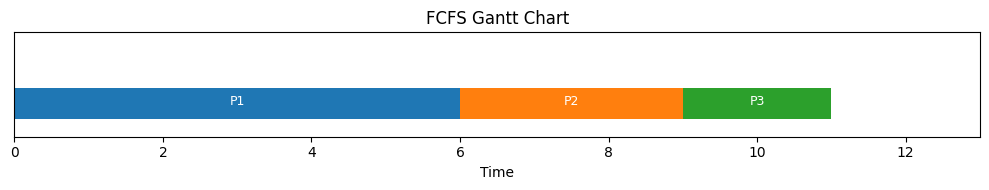


================= SJF (Non-Preemptive) =================
+------+---------+-------+----------+-------+------------+---------+------------+
| P_ID | Arrival | Burst | Priority | Start | Completion | Waiting | Turnaround |
+------+---------+-------+----------+-------+------------+---------+------------+
|  1   |    0    |   6   |    2     |   0   |     6      |    0    |     6      |
|  2   |    2    |   3   |    1     |   8   |     11     |    6    |     9      |
|  3   |    4    |   2   |    3     |   6   |     8      |    2    |     4      |
+------+---------+-------+----------+-------+------------+---------+------------+

Average Waiting Time: 2.67
Average Turnaround Time: 6.33

Gantt Chart:
+------------------------+
|   P1  |   P3  |   P2   |
+-------+-------+--------+
|  0 6  |  6 8  |  8 11  |
+------------------------+


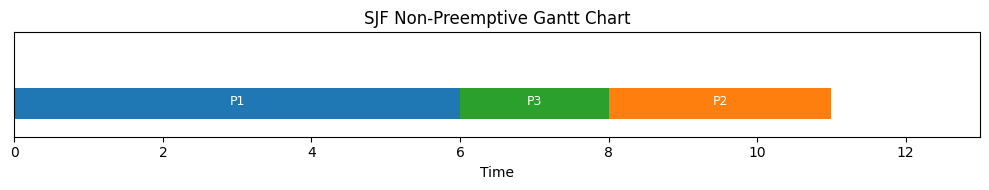


================= SJF (Preemptive) =================
+------+---------+-------+----------+-------+------------+---------+------------+
| P_ID | Arrival | Burst | Priority | Start | Completion | Waiting | Turnaround |
+------+---------+-------+----------+-------+------------+---------+------------+
|  1   |    0    |   6   |    2     |   0   |     11     |    5    |     11     |
|  2   |    2    |   3   |    1     |   2   |     5      |    0    |     3      |
|  3   |    4    |   2   |    3     |   5   |     7      |    1    |     3      |
+------+---------+-------+----------+-------+------------+---------+------------+

Average Waiting Time: 2.00
Average Turnaround Time: 5.67

Gantt Chart:
+--------------------------------+
|   P1  |   P2  |   P3  |   P1   |
+-------+-------+-------+--------+
|  0 2  |  2 5  |  5 7  |  7 11  |
+--------------------------------+


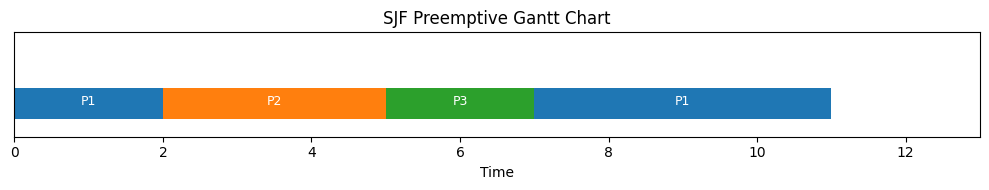


================= Priority (Non-Preemptive) =================
+------+---------+-------+----------+-------+------------+---------+------------+
| P_ID | Arrival | Burst | Priority | Start | Completion | Waiting | Turnaround |
+------+---------+-------+----------+-------+------------+---------+------------+
|  1   |    0    |   6   |    2     |   0   |     6      |    0    |     6      |
|  2   |    2    |   3   |    1     |   6   |     9      |    4    |     7      |
|  3   |    4    |   2   |    3     |   9   |     11     |    5    |     7      |
+------+---------+-------+----------+-------+------------+---------+------------+

Average Waiting Time: 3.00
Average Turnaround Time: 6.67

Gantt Chart:
+------------------------+
|   P1  |   P2  |   P3   |
+-------+-------+--------+
|  0 6  |  6 9  |  9 11  |
+------------------------+


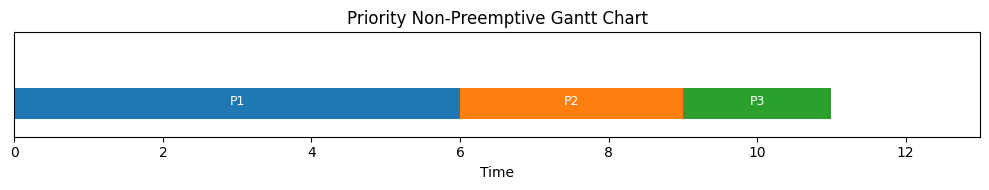


================= Round Robin Scheduling =================
+------+---------+-------+----------+-------+------------+---------+------------+
| P_ID | Arrival | Burst | Priority | Start | Completion | Waiting | Turnaround |
+------+---------+-------+----------+-------+------------+---------+------------+
|  1   |    0    |   6   |    2     |   0   |     11     |    5    |     11     |
|  2   |    2    |   3   |    1     |   2   |     9      |    4    |     7      |
|  3   |    4    |   2   |    3     |   6   |     8      |    2    |     4      |
+------+---------+-------+----------+-------+------------+---------+------------+

Average Waiting Time: 3.67
Average Turnaround Time: 7.33

Gantt Chart:
+------------------------------------------------+
|   P1  |   P2  |   P1  |   P3  |   P2  |   P1   |
+-------+-------+-------+-------+-------+--------+
|  0 2  |  2 4  |  4 6  |  6 8  |  8 9  |  9 11  |
+------------------------------------------------+


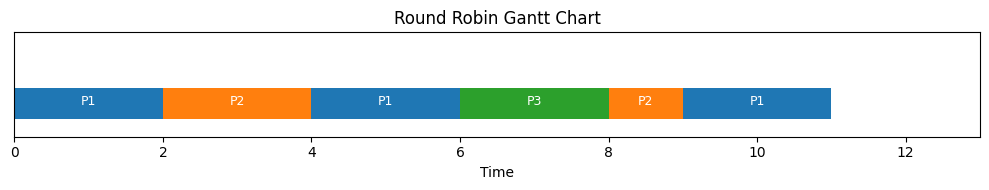

In [8]:
print("CPU Scheduling Algorithms Implementation\n")
n = int(input("Enter the number of processes: "))
print(f"Enter the number of processes: {n}")
processes_input = []
for i in range(n):
    print(f"\nProcess {i+1}:")
    at = int(input("Arrival Time: "))
    print("Arrival Time:", at)
    bt = int(input("Burst Time: "))
    print("Burst Time:", bt)
    pr = int(input("Priority (lower = higher priority): "))
    print("Priority (lower = higher priority):", pr)
    processes_input.append(
        {"id": i + 1, "arrival_time": at, "burst_time": bt, "priority": pr}
    )

# Create deep copies for each scheduling algorithm
processes_fcfs = copy.deepcopy(processes_input)
processes_sjf_np = copy.deepcopy(processes_input)
processes_sjf_p = copy.deepcopy(processes_input)
processes_prio_np = copy.deepcopy(processes_input)
processes_rr = copy.deepcopy(processes_input)

tq = int(input("\nEnter Time Quantum for Round Robin: "))
print("Enter Time Quantum for Round Robin:", tq)

# 1. FCFS
print("\n================= FCFS Scheduling =================")
scheduled_fcfs, gantt_fcfs = fcfs_scheduling(processes_fcfs)
print_results(scheduled_fcfs)
print_gantt_chart_text(gantt_fcfs)
plot_gantt_chart(gantt_fcfs, "FCFS Gantt Chart")

# 2. SJF Non-Preemptive
print("\n================= SJF (Non-Preemptive) =================")
scheduled_sjf_np, gantt_sjf_np = sjf_non_preemptive(processes_sjf_np)
print_results(scheduled_sjf_np)
print_gantt_chart_text(gantt_sjf_np)
plot_gantt_chart(gantt_sjf_np, "SJF Non-Preemptive Gantt Chart")

# 3. SJF Preemptive
print("\n================= SJF (Preemptive) =================")
scheduled_sjf_p, gantt_sjf_p = sjf_preemptive(processes_sjf_p)
print_results(scheduled_sjf_p)
print_gantt_chart_text(gantt_sjf_p)
plot_gantt_chart(gantt_sjf_p, "SJF Preemptive Gantt Chart")

# 4. Priority (Non-Preemptive)
print("\n================= Priority (Non-Preemptive) =================")
scheduled_prio, gantt_prio = priority_non_preemptive(processes_prio_np)
print_results(scheduled_prio)
print_gantt_chart_text(gantt_prio)
plot_gantt_chart(gantt_prio, "Priority Non-Preemptive Gantt Chart")

# 5. Round Robin
print("\n================= Round Robin Scheduling =================")
scheduled_rr, gantt_rr = round_robin(processes_rr, tq)
print_results(scheduled_rr)
print_gantt_chart_text(gantt_rr)
plot_gantt_chart(gantt_rr, "Round Robin Gantt Chart")